In [1]:
# Librerías principales
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, LassoCV
from sklearn.model_selection import StratifiedKFold
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Definir la ruta al archivo
ruta_dta = "C:/SEM 8/Bloque dos & materias final/Proyecto BeWay/tablas & codigos/dtas/BASE_LOGIT.dta"

# Leer el archivo .dta
data = pd.read_stata(ruta_dta)

# Ver las primeras filas para asegurarnos
print(data.head())


   sexo  edad_v  gasto_mensual  ingreso_ideal  tiene_tarjeta  utilizo_ahorros  \
0     1      51           1500        13000.0              0              NaN   
1     0      41           5000        12000.0              0              0.0   
2     1      41           4000         8000.0              0              NaN   
3     0      73           2400            NaN              0              NaN   
4     0      50              0            NaN              0              NaN   

   atraso_credito  darse_gusto  adelanto_pagos  monto_max_deuda_patr  ...  \
0             NaN          0.0             0.0                2000.0  ...   
1             0.0          NaN             NaN                   NaN  ...   
2             NaN          0.0             0.0               10000.0  ...   
3             NaN          0.0             0.0                   NaN  ...   
4             NaN          0.0             0.0                   NaN  ...   

   impulsivid  nivel_deuda  hace_no_piensa  cuesta

In [3]:
# Contar filas sin nan variables tiene el DataFrame
print("Número de filas sin NaN en el DataFrame:", data.dropna().shape[0])

#mostrar los nombres de las columnas
print("Nombres de las columnas en el DataFrame:", data.columns.tolist())


Número de filas sin NaN en el DataFrame: 0
Nombres de las columnas en el DataFrame: ['sexo', 'edad_v', 'gasto_mensual', 'ingreso_ideal', 'tiene_tarjeta', 'utilizo_ahorros', 'atraso_credito', 'darse_gusto', 'adelanto_pagos', 'monto_max_deuda_patr', 'monto_max_deuda_mens', 'cumple_registro', 'no_registra', 'no_tiempo', 'registro_aburrido', 'no_pensado', 'no_sabe_como', 'ingreso_mensual', 'gra_control', 'impulsivid', 'nivel_deuda', 'hace_no_piensa', 'cuesta_habitos', 'prefiere_credito', 'gasta_no_ahorra', 'satisfaccion_gastar', 'nivel_estres', 'nivel_bienestar', 'pob_objetivo']


In [4]:
from IPython.display import display
display(data)

,sexo,edad_v,gasto_mensual,ingreso_ideal,tiene_tarjeta,utilizo_ahorros,atraso_credito,darse_gusto,adelanto_pagos,monto_max_deuda_patr,...,impulsivid,nivel_deuda,hace_no_piensa,cuesta_habitos,prefiere_credito,gasta_no_ahorra,satisfaccion_gastar,nivel_estres,nivel_bienestar,pob_objetivo
0,1,51,1500,13000.0,0,NaN,NaN,0.0,0.0,2000.0,...,0,2.0,1.0,2.0,1.0,3.0,0.0,1.0,3.0,0.0
1,0,41,5000,12000.0,0,0.0,0.0,NaN,NaN,NaN,...,0,2.0,0.0,2.0,1.0,2.0,0.0,1.0,3.0,0.0
2,1,41,4000,8000.0,0,NaN,NaN,0.0,0.0,10000.0,...,1,NaN,2.0,1.0,0.0,0.0,1.0,3.0,4.0,NaN
3,0,73,2400,NaN,0,NaN,NaN,0.0,0.0,NaN,...,0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN
4,0,50,0,NaN,0,NaN,NaN,0.0,0.0,NaN,...,1,NaN,3.0,1.0,0.0,0.0,0.0,2.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20443,1,59,2000,4000.0,0,0.0,0.0,NaN,NaN,0.0,...,0,NaN,0.0,1.0,3.0,0.0,1.0,3.0,1.0,NaN
20444,0,19,2000,3000.0,0,NaN,NaN,0.0,0.0,0.0,...,0,NaN,0.0,2.0,0.0,2.0,3.0,2.0,2.0,NaN
20445,0,54,1200,7000.0,0,NaN,NaN,0.0,0.0,50000.0,...,0,NaN,2.0,1.0,0.0,0.0,1.0,3.0,2.0,NaN
20446,1,38,4000,8000.0,0,NaN,NaN,0.0,0.0,100000.0,...,0,1.0,2.0,2.0,2.0,0.0,1.0,1.0,3.0,0.0


In [5]:
# Imputación de valores faltantes

# Filtrar por pob_objetivo e ingreso_mensual no NA
# El ingreso también debe ser mayor a 0 (personas que generan ingresos)

data = data[data['pob_objetivo'].notna()]
data = data[data['ingreso_mensual'].notna()]
data = data[data['ingreso_mensual'] > 0]


# Lista de variables binarias (convertir NA a 0)
vars_bin = [
    'utilizo_ahorros',
    'atraso_credito',
    'darse_gusto',
    'adelanto_pagos',
    'cumple_registro',
    'no_registra',
    'no_tiempo',
    'registro_aburrido',
    'no_pensado',
    'no_sabe_como',
]

# Lista de variables continuas (excepto nivel_deuda)
vars_niv = [
    'gasto_mensual',
    'ingreso_ideal',
    'monto_max_deuda_patr',
    'monto_max_deuda_mens',
]

# Convertir NA de vars_bin a 0
for var in vars_bin:
    if var in data.columns:  # Verificar que la columna exista
        data[var] = data[var].fillna(0).astype(int)  # Convertir a int directamente

# Convertir NA de vars_niv a 0
for var in vars_niv:
    if var in data.columns:  # Verificar que la columna exista
        data[var] = data[var].fillna(0)

# Llenar los valores faltantes de nivel_deuda con 0 (sin convertirla en relativa al ingreso)
if 'nivel_deuda' in data.columns:
    data['nivel_deuda'] = data['nivel_deuda'].fillna(0)

# Convertir vars_niv a valores relativos a ingreso_mensual
for var in vars_niv:
    if var in data.columns and 'ingreso_mensual' in data.columns:  # Verificar columnas
        data[var] = data[var] / data['ingreso_mensual']

# Verificar el resultado
print(data.head())


    sexo  edad_v  gasto_mensual  ingreso_ideal  tiene_tarjeta  \
1      0      41       0.465116       1.116279              0   
8      0      47       1.000000       1.000000              0   
11     1      36       0.733333       1.500000              1   
13     0      55       0.465116       1.550388              1   
16     0      33       0.775194       1.356589              0   

    utilizo_ahorros  atraso_credito  darse_gusto  adelanto_pagos  \
1                 0               0            0               0   
8                 0               0            1               1   
11                0               0            0               0   
13                0               0            0               1   
16                0               0            0               0   

    monto_max_deuda_patr  ...  impulsivid  nivel_deuda  hace_no_piensa  \
1               0.000000  ...           0          2.0             0.0   
8               0.500000  ...           1          2

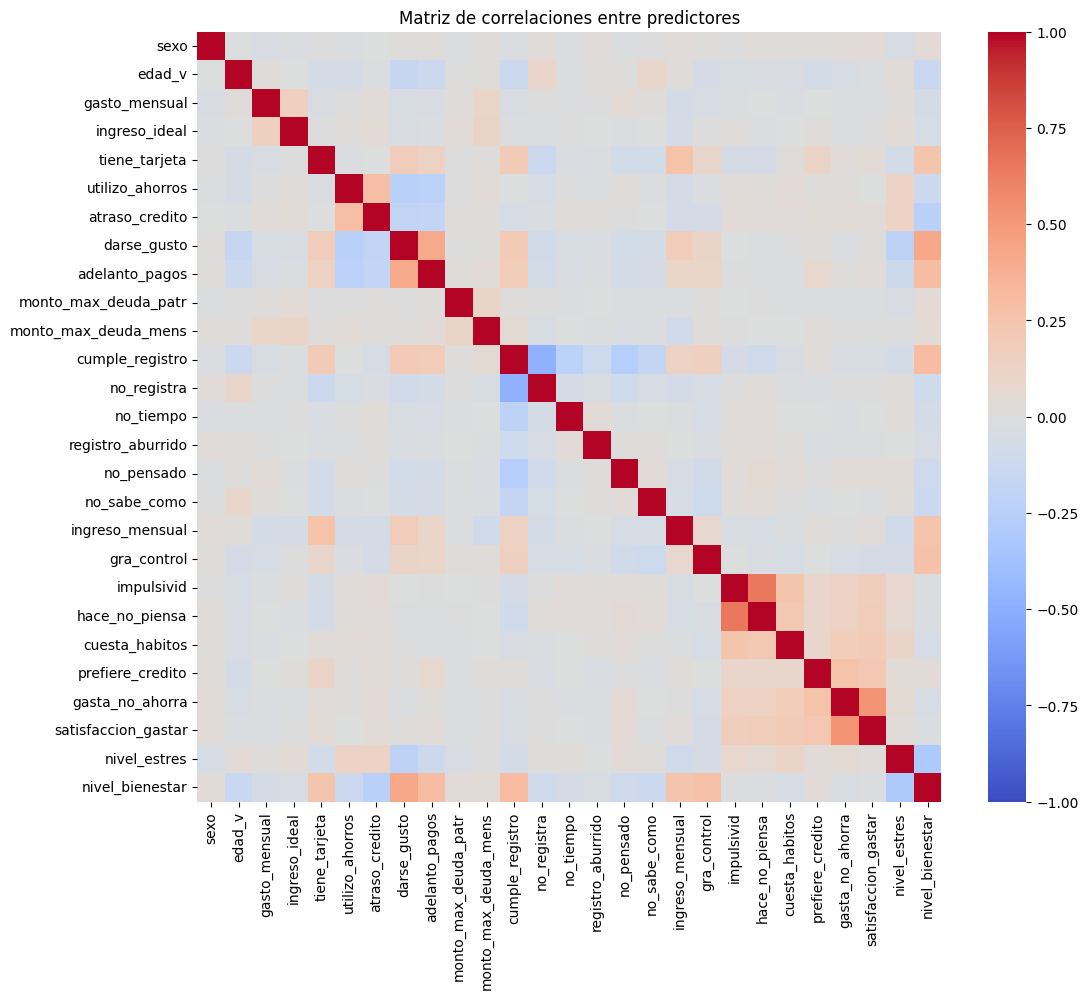

In [6]:

import seaborn as sns
import matplotlib.pyplot as plt

# Selecciona solo las variables predictoras numéricas
X = data.drop(columns=['pob_objetivo', 'nivel_deuda'])

# Calcula la matriz de correlación
corr_matrix = X.corr()

# Visualiza con mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, center=0, vmin=-1, vmax=1)
plt.title("Matriz de correlaciones entre predictores")
plt.show()


In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

X = data.drop(columns=['pob_objetivo', 'nivel_deuda'])
X = add_constant(X)  # añade la constante para que funcione con statsmodels

vif_data = pd.DataFrame()
vif_data['variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                variable        VIF
0                  const  51.284224
1                   sexo   1.010608
2                 edad_v   1.081061
3          gasto_mensual   1.045991
4          ingreso_ideal   1.044429
5          tiene_tarjeta   1.168619
6        utilizo_ahorros   1.188150
7         atraso_credito   1.170267
8            darse_gusto   1.462129
9         adelanto_pagos   1.302524
10  monto_max_deuda_patr   1.017267
11  monto_max_deuda_mens   1.053828
12       cumple_registro   1.944418
13           no_registra   1.554226
14             no_tiempo   1.124646
15     registro_aburrido   1.033251
16            no_pensado   1.192662
17          no_sabe_como   1.088907
18       ingreso_mensual   1.153195
19           gra_control   1.102353
20            impulsivid   1.793898
21        hace_no_piensa   1.785110
22        cuesta_habitos   1.121775
23      prefiere_credito   1.115207
24       gasta_no_ahorra   1.440316
25   satisfaccion_gastar   1.441617
26          nivel_estres   1

In [8]:
# MODELO LOGIT simple

#variables predictoras
vars_predict = [col for col in data.columns if col != ['pob_objetivo', 'nivel_deuda']]

X = data.drop(columns=['pob_objetivo', 'nivel_deuda'])  # si aún quieres inferencia
y = data['pob_objetivo']

X = sm.add_constant(X, has_constant='add')
modelo = sm.Logit(y, X).fit()
print(modelo.summary())




Optimization terminated successfully.
         Current function value: 0.389108
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           pob_objetivo   No. Observations:                 6810
Model:                          Logit   Df Residuals:                     6782
Method:                           MLE   Df Model:                           27
Date:                Wed, 07 May 2025   Pseudo R-squ.:                  0.1171
Time:                        20:47:07   Log-Likelihood:                -2649.8
converged:                       True   LL-Null:                       -3001.4
Covariance Type:            nonrobust   LLR p-value:                8.064e-131
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.4198      0.246     -5.763      0.000      -1.903      -0.937

In [10]:
for col in X.columns:
    tab = pd.crosstab(X[col], y)
    print(f"Variable: {col}")
    print(tab)
    print("-" * 40)


Variable: const
pob_objetivo   0.0   1.0
const                   
1.0           5716  1094
----------------------------------------
Variable: sexo
pob_objetivo   0.0  1.0
sexo                   
0             2881  561
1             2835  533
----------------------------------------
Variable: edad_v
pob_objetivo  0.0  1.0
edad_v                
18             42    2
19             70    4
20             72   10
21             81   12
22             99   12
...           ...  ...
79              2    0
80              2    0
81              1    0
82              1    0
98              2    0

[66 rows x 2 columns]
----------------------------------------
Variable: gasto_mensual
pob_objetivo   0.0  1.0
gasto_mensual          
0.000000        16    1
0.011865         1    0
0.016611         1    0
0.020764         1    0
0.023256         1    0
...            ...  ...
155.037209       2    0
232.555814       1    0
237.527316       2    0
249.997500       1    0
333.330000       1    0


In [11]:
odds_ratios = np.exp(modelo.params)
print(odds_ratios)


const                   0.241762
sexo                    1.018587
edad_v                  1.007449
gasto_mensual           0.992326
ingreso_ideal           1.001686
tiene_tarjeta           1.101427
utilizo_ahorros         1.193839
atraso_credito          2.561827
darse_gusto             0.497620
adelanto_pagos          0.939027
monto_max_deuda_patr    1.000383
monto_max_deuda_mens    0.983561
cumple_registro         1.047073
no_registra             0.816930
no_tiempo               1.015790
registro_aburrido       0.853373
no_pensado              0.703551
no_sabe_como            0.777500
ingreso_mensual         1.000002
gra_control             0.982710
impulsivid              1.061183
hace_no_piensa          1.032477
cuesta_habitos          1.004157
prefiere_credito        1.045801
gasta_no_ahorra         0.959976
satisfaccion_gastar     1.103386
nivel_estres            1.290028
nivel_bienestar         0.593903
dtype: float64


In [12]:
mfx = modelo.get_margeff()
print(mfx.summary())


        Logit Marginal Effects       
Dep. Variable:           pob_objetivo
Method:                          dydx
At:                           overall
                          dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
sexo                     0.0022      0.008      0.261      0.794      -0.014       0.019
edad_v                   0.0009      0.000      2.618      0.009       0.000       0.002
gasto_mensual           -0.0009      0.001     -1.268      0.205      -0.002       0.001
ingreso_ideal            0.0002      0.000      0.565      0.572      -0.000       0.001
tiene_tarjeta            0.0116      0.010      1.180      0.238      -0.008       0.031
utilizo_ahorros          0.0212      0.012      1.828      0.068      -0.002       0.044
atraso_credito           0.1126      0.012      9.254      0.000       0.089       0.136
darse_gusto             -0.0835      0.014     

In [13]:
#PREPARAR UN LASSO PARA EL LOGIT
# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar (importante para Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [14]:
# Lasso con validación cruzada para elegir C óptimo
lasso = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty='l1',
    solver='liblinear',
    scoring='neg_log_loss',
    random_state=42
)
lasso.fit(X_train_scaled, y_train)


LogisticRegressionCV(cv=5, penalty='l1', random_state=42,
                     scoring='neg_log_loss', solver='liblinear')

In [15]:
coef = lasso.coef_.flatten()
selected_vars = pd.Series(coef, index=X.columns)
print("Variables seleccionadas por LASSO (coef ≠ 0):")
print(selected_vars[selected_vars != 0])

Variables seleccionadas por LASSO (coef ≠ 0):
edad_v                 0.032438
gasto_mensual         -0.001431
tiene_tarjeta          0.010512
utilizo_ahorros        0.054602
atraso_credito         0.258442
darse_gusto           -0.278705
cumple_registro        0.024098
no_registra           -0.041015
registro_aburrido     -0.000073
no_pensado            -0.036507
no_sabe_como          -0.014985
ingreso_mensual        0.021860
hace_no_piensa         0.013026
cuesta_habitos         0.005058
prefiere_credito       0.014691
satisfaccion_gastar    0.043385
nivel_estres           0.162224
nivel_bienestar       -0.457404
dtype: float64


In [16]:
#NUEVO LOGIT CON VARIABLES SELECCIONADAS
# Filtrar columnas con coef ≠ 0
X_sel = X[selected_vars[selected_vars != 0].index]
X_sel_const = sm.add_constant(X_sel)

# Ajustar logit clásico
modelo_sel = sm.Logit(y, X_sel_const).fit()
print(modelo_sel.summary())

Optimization terminated successfully.
         Current function value: 0.389327
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           pob_objetivo   No. Observations:                 6810
Model:                          Logit   Df Residuals:                     6791
Method:                           MLE   Df Model:                           18
Date:                Thu, 08 May 2025   Pseudo R-squ.:                  0.1167
Time:                        14:43:50   Log-Likelihood:                -2651.3
converged:                       True   LL-Null:                       -3001.4
Covariance Type:            nonrobust   LLR p-value:                5.030e-137
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.4536      0.230     -6.310      0.000      -1.905      -1.002
ed

In [17]:
mfx = modelo_sel.get_margeff()
print(mfx.summary())


        Logit Marginal Effects       
Dep. Variable:           pob_objetivo
Method:                          dydx
At:                           overall
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
edad_v                  0.0009      0.000      2.657      0.008       0.000       0.002
gasto_mensual          -0.0008      0.001     -1.236      0.217      -0.002       0.000
tiene_tarjeta           0.0112      0.010      1.146      0.252      -0.008       0.030
utilizo_ahorros         0.0222      0.011      1.934      0.053      -0.000       0.045
atraso_credito          0.1137      0.012      9.405      0.000       0.090       0.137
darse_gusto            -0.0855      0.014     -6.298      0.000      -0.112      -0.059
cumple_registro         0.0044      0.011      0.415      0.678      -0.016       0.025
no_registra            -0.0244      0.012     -1.994    

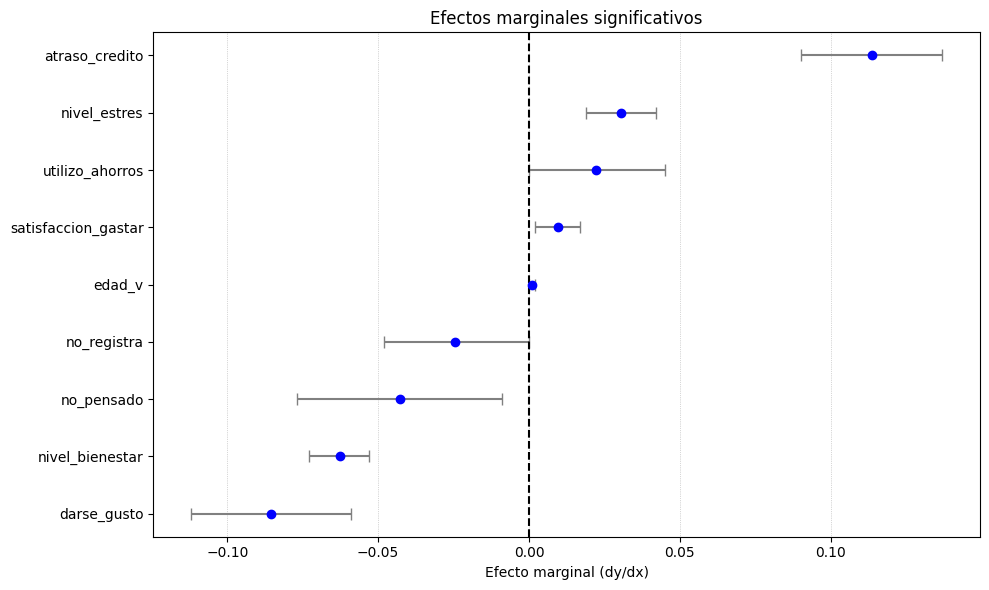

In [28]:

# Crear DataFrame manualmente con las variables significativas
data = {
    'Variable': [
        'edad_v', 'utilizo_ahorros', 'atraso_credito', 'darse_gusto',
        'no_registra', 'no_pensado', 'satisfaccion_gastar',
        'nivel_estres', 'nivel_bienestar'
    ],
    'dy_dx': [0.0009, 0.0222, 0.1137, -0.0855, -0.0244, -0.0428, 0.0096, 0.0304, -0.0628],
    'std_err': [0.000, 0.011, 0.012, 0.014, 0.012, 0.017, 0.004, 0.006, 0.005],
    'ci_low': [0.000, -0.000, 0.090, -0.112, -0.048, -0.077, 0.002, 0.019, -0.073],
    'ci_up': [0.002, 0.045, 0.137, -0.059, -0.000, -0.009, 0.017, 0.042, -0.053]
}

df = pd.DataFrame(data)
df = df.sort_values(by='dy_dx')

# Graficar
plt.figure(figsize=(10, 6))
plt.errorbar(
    x=df['dy_dx'],
    y=df['Variable'],
    xerr=[df['dy_dx'] - df['ci_low'], df['ci_up'] - df['dy_dx']],
    fmt='o',
    color='blue',
    ecolor='gray',
    capsize=4
)
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Efecto marginal (dy/dx)')
plt.title('Efectos marginales significativos')
plt.tight_layout()
plt.grid(True, axis='x', linestyle=':', linewidth=0.5)
plt.show()

